# Lesson 4 Batch Processing and Tracking

Congratulations, you've just completed an awesome image processing pipeline that takes an image and does something rather useful. You've tested it a few times and you're happy with the results. Now you need to apply the same operation to 1000 images. Maybe you need to apply them to 20 datasets with slightly different parameters. Maybe you need to aggreagate information across the results of each processed image to make your conclusions. Doing this can be hard, but sometimes it's so easy you can see many ways to approach this, and are not sure which one is the best. Let's talk about what you need to keep in mind when building systems to actually apply your pipeline.

## 4.1 Batch processing strategies (vertical and horizontal integration)

In [1]:
%matplotlib inline

**Exercise** You're at the point where you have the functions below. How might you apply the pipeline you developed to every image in a folder, saving the results in a list?

In [4]:
from skimage.io import imread

def loading(image_file_name):
    return imread(image_file_name)

def preprocessing(image):
    process_image = None
    return process_image # real code would go here

def info_extraction(image):
    results = None
    return results

data_folder = "/Users/ahmedelkaffas/Documents/Repositories/DataLucense/dev-summer2018/Data_ConfocalDrugPanel/"

In [5]:
import os
os.chdir(data_folder)
listdir = os.listdir

In [8]:
files = [f for f in listdir(data_folder) if '.tif' in f]
print(files);

['drugA.tif', 'DMSO.tif', 'temp_DMSO.tif']


In [7]:
results = []
for f in files:
    img = loading(f)
    processed = preprocessing(img)
    result = info_extraction(processed)
    results.append(result)

### Example: counting cell numbers from 5 images with cell division at different time point.

In [9]:
from skimage.io import imread
def loading(image_file_name):
    return imread(image_file_name)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import median_filter
from skimage import filters
import skimage.morphology as sm
def preprocessing(image):
    # filtering and thresholding
    filtered = median_filter(image, size=2)
    otsu_thresh = filters.threshold_otsu(filtered)
    masked = filtered > otsu_thresh-20 #smaller threshold than otsu      
    # morphology
    morph = sm.binary_erosion(masked,sm.disk(3)) 
    return morph

from skimage.measure import label
from skimage.measure import regionprops
def info_extraction(image):
    # labeling
    cell_labels = label(image)
    cell_number = np.amax(cell_labels)
    plt.imshow(cell_labels)
    return cell_number 

Cell Numbers in Each Image: [20, 22, 21, 21, 22]


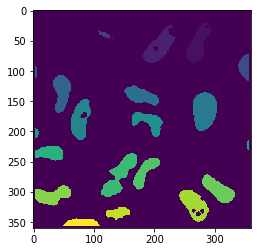

In [91]:
data_folder = "../images-master-2017/data/batch_tracking"

import os
from skimage.measure import regionprops
os.chdir(data_folder)
listdir = os.listdir

files = [f for f in listdir(data_folder) if '.tif' in f]

results = []
for f in files:
    img = loading(f)
    #plt.imshow(img)
    processed = preprocessing(img[:,:,0])
    #plt.imshow(processed)
    tmp_result = info_extraction(processed)
    results.append(tmp_result)
    
print('Cell Numbers in Each Image:',results)

What made this a pretty straightforward proceedure is that we encapsulated _everything_ in a function. If we developed our pipeline without doing this, we could wrap everthing in a giant function which took as parameters everything we needed.

In [10]:
def whole_pipeline(image_file_name):
    pass # code would go here

This may not be the best idea. Maybe next week you want to load similar images the same way, preprocess them differently, then extract the same information. You could have imported the `loading` and `info_extraction` you already have.

You may also be thinking of an alternative way of solving this problem that looks like this.

In [11]:
files = [f for f in listdir(data_folder) if '.tif' in f]
images = []
processed = []
results = []

for f in files:
    images.append(loading(f))
    
for img in images:
    processed.append(preprocessing(img[:,:,0]))
    
for proc in processed:
    results.append(info_extraction(proc))

print('Cell Numbers in Each Image:',results)

/Users/ahmedelkaffas/anaconda/lib/python3.6/site-packages/skimage/filters/thresholding.py:271: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (10, 819, 3) looks like an RGB image
  warn(msg.format(image.shape))


RuntimeError: structure and input must have same dimensionality

Instead of applying all processing steps to each image one at a time, you can apply each processing step to each image. So now rather than completing your pipline "vertically", from start to finish, top to bottom, you are completing your pipeline "horizontally", applying each stage across the board in sequence.

TODO: graphics of horizontal and vertical strategies

In fact, when you've made your code modular with little functions, Python tries to support this approach with _functional programming tools_. We'll talk about one of the especially useful ones:

- `map(function, iterable)`. Applies `function` to each element in `iterable` (i.e. anything you can loop through) and gives you a new list with the results.

In [13]:
files = [f for f in listdir(data_folder) if '.tif' in f]
images = map(loading, files)
processed = map(preprocessing,images)
results = map(info_extraction, processed)

Now this looks like a pretty concise way to process a pipeline! But is it the best way?

One thing to consider is that at the end of the program, `files`, `images`, `processed`, and `results` are all full arrays available to you in program memmory. This could be useful for debugging (did everything look good after preprocessing?). It may also be useful because you need to aggregated across intermediate results. Maybe you only want to use images where the background level is $\pm 10\%$ of the median across all images in your experiment (if Otsu's method sets the background threshold very high or low, it's suspicious).

The downside of having all the intermediate information is that it may use a lot of memory.

**Exercise** Not all lines above are as memory intensive as the others. Which line is the least offensive?

**Exercise** in our lesson on loading an image we discussed how much memory an image can use up. If you are processing 1000 16-bit, 1024x1024 pixel images each with 3 channels, how much memory does the first line above use?

In [14]:
num_bytes = 1000 * 2 * 1024**2 * 3
print("{} Bytes".format(num_bytes))
print("{} GB".format(num_bytes / 1024.**3))

6291456000 Bytes
5.859375 GB


That's probably not going to go smoothly if you have a multi-stage pipeline. You could delete each stage as you go, keeping in memory only the last and current stage using `del` stagements, e.g. `del images`, but this can introduce bugs and still requires you to keep copies of everything. For very large numbers of images, this strategy suffers.

A good way to design a pipeline is to draw out the pipes. Map out the dependencies between pieces of information so you can see where to break things into functions and figure out how much data you actually need to keep in memory. The example below is a workflow for processing a green structural channel and a red calcium fluorescence channel in a 60-frame time series of images. The goal is to find cells, make masks, and track the fluorescence intensities over time.

![Diagram of a pipeline](pipeline_diagrams.png "A typical pipeline diagram")

What are some observations we can make once we've drawn out this plan? We can see that loading raw images and preprocessing them can be done with one function, applied image-by-image, without saving the intermediate. However we need to stop after this and max project. We can then remove all of the green channel data from memory and work on the red channel, keeping only the cell location masks. We then apply the cell location masks to each image, one at a time, take out resulting total cell intensities and save them in an array.

Without doing this we may have tried to load both channels at once. This approach reduces our memory consumption by 50%.

---------------------------------------------------------------------------------------------------------------------

# 4.2 Tracking objects / pipeline design

It is important to be able to order the various image processing tools you have learnt in an automated pipeline so you don't have to apply the same N transformations over and over again to your dataset of M images. Today wou will learn how to build your very own image processing pipeline, along with some nifty video processing tools.

We will do this in the context of an image processing method known as "tracking". You already know how to identify separate objects in your images and measure their properties (position, size, intensity etc.). Now imagine you have a time-series of images (or a video...). Tracking is essentially the ability to identify the same object in your entire time-series consistently. We will also demonstrate how this process can fail, and what to watch out for when you are analyzing your own data.

#### Here may need modify, please the position assignment for each object may not be accurate or even messed up when multiple objects.
#### Similarity tracking may be more universal (optical flow)?

In [15]:
%matplotlib inline
from moviepy import editor as mpy

ModuleNotFoundError: No module named 'moviepy'

In [18]:
vid_file_name = "/Users/ahmedelkaffas/Documents/Repositories/DataLucense/dev-summer2018/Data_BatchTracking/CellVideo.mp4"
vid = mpy.VideoFileClip(vid_file_name)
mpy.ipython_display(vid, width=480)

NameError: name 'mpy' is not defined

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
StartTime = 1.0; #second
frame = vid.get_frame(StartTime)
red = frame[90:340,15:240,0] # choose a sample region with consistent cell numbers
plt.imshow(red)

NameError: name 'vid' is not defined

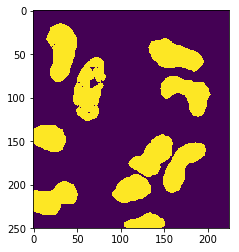

In [78]:
from scipy.ndimage.filters import median_filter
from skimage import filters
import skimage.morphology as sm

median_filter_size = 2
filtered = median_filter(red, size=median_filter_size)
otsu_thresh = filters.threshold_otsu(filtered)
red_masked = filtered > otsu_thresh-10 #smaller threshold than otsu
red_morph = sm.binary_opening(red_masked,sm.disk(3))
plt.imshow(red_morph)

10


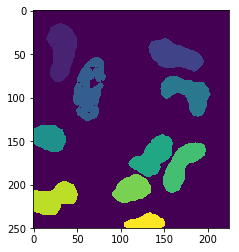

In [79]:
from skimage.measure import label
cell_labels = label(red_morph)
print(cell_labels.max())
plt.imshow(cell_labels)

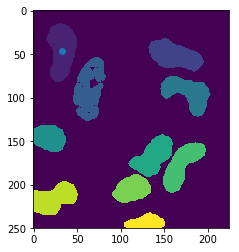

In [80]:
from skimage.measure import regionprops
props = regionprops(cell_labels)
props[0].centroid
xx = props[0].centroid[0]
yy = props[0].centroid[1]
plt.imshow(cell_labels)
plt.plot(yy,xx, 'o')

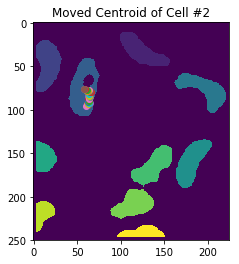

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import median_filter
from skimage import filters
import skimage.morphology as sm
from skimage.measure import regionprops

median_filter_size = 2

StartTime = 1.0; #second
StartFrame = int(StartTime*vid.fps)+1
EndFrame = int(vid.duration * vid.fps)+1
num_frames = EndFrame - StartFrame;

cell_position = np.zeros((num_frames, 2))

for frame_num, frame in enumerate(vid.iter_frames()):
    if frame_num>=StartFrame:
        red = frame[90:340,15:240,0]
        
        # filtering and thresholding
        filtered = median_filter(red, size=median_filter_size)
        otsu_thresh = filters.threshold_otsu(filtered)
        red_masked = filtered > otsu_thresh-10 #smaller threshold than otsu
        
        # morphology
        red_morph = sm.binary_erosion(red_masked,sm.disk(3))
        
        # labeling
        cell_labels = label(red_morph)
        props = regionprops(cell_labels)
        position = props[2].centroid

        cell_position[frame_num-StartFrame, :] = position 
        
        xx = props[2].centroid[0]
        yy = props[2].centroid[1]
        plt.imshow(cell_labels)
        plt.plot(yy,xx, 'o')
        plt.title('Moved Centroid of Cell #2')

Text(0.5,1,'Cell Centroid Position')

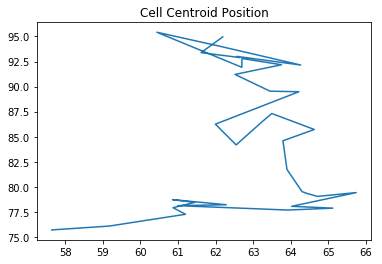

In [82]:
plt.plot(cell_position[:,1], cell_position[:,0])
plt.title('Cell Centroid Position')

Text(0.5,1,'Motion Distance')

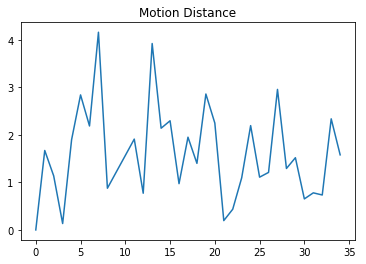

In [83]:
import math

frameNum = len(cell_position)
cell_distance = np.zeros(frameNum-1)

for nframe in range(1,frameNum-1):
    x1 = cell_position[nframe-1,0]
    y1 = cell_position[nframe-1,1]
    x2 = cell_position[nframe,0]
    y2 = cell_position[nframe,1]
    
    cell_distance[nframe]= math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    
plt.plot(cell_distance)
plt.title('Motion Distance')

### ***Additional links of useful functions for real cases